# Decision Tree Method

## Imports that will be needed

In [55]:
import pandas as pd
import numpy as np                     # Llibreria matematica
import sklearn 
from sklearn import tree
from sklearn.metrics import confusion_matrix
from scipy.stats import binomtest
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

pd.set_option('display.max_columns', None)


## Read training and testing datasets

In [56]:
dfTrain = pd.read_csv(r'../Datasets/training-dataset-reduced.csv')
dfTest = pd.read_csv(r'../Datasets/testing-dataset-reduced.csv')

#Remove Unnamed column generated in preprocessing
dfTrain = dfTrain[dfTrain.filter(regex='^(?!Unnamed)').columns]
dfTest = dfTest[dfTest.filter(regex='^(?!Unnamed)').columns] 

#Sepparate the column that we want to predict
X_train, y_train = dfTrain.drop('y', axis=1), dfTrain["y"]
X_test, y_test = dfTest.drop('y', axis=1), dfTest["y"]


## Build the tree

0.8610861086108611


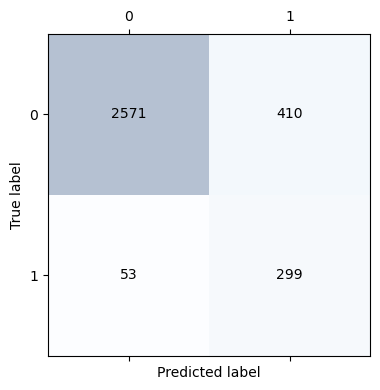


Accuracy: 0.8610861086108611

              precision    recall  f1-score   support

         0.0       0.98      0.86      0.92      2981
         1.0       0.42      0.85      0.56       352

    accuracy                           0.86      3333
   macro avg       0.70      0.86      0.74      3333
weighted avg       0.92      0.86      0.88      3333


23


In [57]:

clf = tree.DecisionTreeClassifier(criterion='entropy')
clf = clf.fit(X_train, y_train)
pred = clf.predict(X_test)

# Obtain accuracy score of learned classifier on test data
print(clf.score(X_test, y_test))
confmat = confusion_matrix(y_test, pred)
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center',fontsize=10)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()
print()
print("Accuracy:", sklearn.metrics.accuracy_score(y_test, pred))
print()
print(sklearn.metrics.classification_report(y_test, pred))
epsilon = sklearn.metrics.accuracy_score(y_test, pred)
result = binomtest(k=int(epsilon*X_test.shape[0]), n=X_test.shape[0], p=0.05)
result.proportion_ci()

print()
print(clf.tree_.max_depth)

#Print tree
#fig = plt.gcf()
#fig.set_size_inches(200, 100)

#tree.plot_tree(clf, filled=True,rounded=True,feature_names=list(X_train.columns.values))
#fig.savefig('tree.png')
#plt.show()

## Improve results

As can be seen in the last print, the height of the decission tree is very high, and this can lead to overfit. Let's see if configuring some parameters using GridSearchCV we achieve a more general tree that does not worse considerably the metrics. This search will do 10 fold cross validation with the training dataset, and this, should avoid overfitting.

First, let's limit loosely the max depth being betweeen 5 and 15

In [58]:

params = {'min_impurity_decrease': list(np.linspace(0,0.5,50)),'min_samples_split':list(range(2,20,1)), 'max_depth' : list(range(5,15,1))}
clfGS = GridSearchCV(tree.DecisionTreeClassifier(criterion='entropy'), param_grid=params,cv=10,n_jobs=-1)  # If cv is integer, by default is Stratifyed 
clfGS.fit(X_train, y_train)
print("Best Params=",clfGS.best_params_, "Accuracy=", clfGS.best_score_)

Best Params= {'max_depth': 9, 'min_impurity_decrease': 0.0, 'min_samples_split': 13} Accuracy= 0.8768523395959678


0.8532853285328533


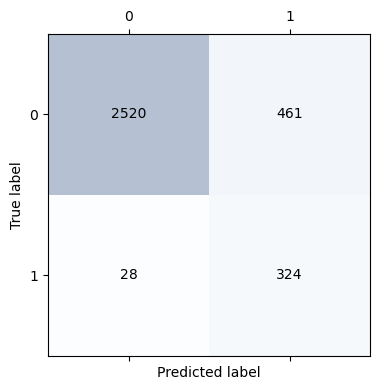


Accuracy: 0.8532853285328533

              precision    recall  f1-score   support

         0.0       0.99      0.85      0.91      2981
         1.0       0.41      0.92      0.57       352

    accuracy                           0.85      3333
   macro avg       0.70      0.88      0.74      3333
weighted avg       0.93      0.85      0.88      3333


9


In [59]:
clf9=tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=clfGS.best_params_['min_samples_split'],min_impurity_decrease=clfGS.best_params_['min_impurity_decrease'], max_depth= clfGS.best_params_['max_depth'])
clf9 = clf9.fit(X_train, y_train)
pred = clf9.predict(X_test)
# Obtain accuracy score of learned classifier on test data
print(clf9.score(X_test, y_test))
confmat = confusion_matrix(y_test, pred)
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center',fontsize=10)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()
print()
print("Accuracy:", sklearn.metrics.accuracy_score(y_test, pred))
print()
print(sklearn.metrics.classification_report(y_test, pred))
epsilon = sklearn.metrics.accuracy_score(y_test, pred)
result = binomtest(k=int(epsilon*X_test.shape[0]), n=X_test.shape[0], p=0.05)
result.proportion_ci()

print()
print(clf9.tree_.max_depth)
#Print tree
fig = plt.gcf()
fig.set_size_inches(200, 100)

tree.plot_tree(clf9, filled=True,rounded=True,feature_names=list(X_train.columns.values))
fig.savefig('../Plots/Trees/treeDepth9.png')
plt.show()

Since in the feature selection we found that the best number of features is 8, 9 let's see first how many features are we using


. And, with the GridSearch the F-Measure has even increased. But, let's see if with a tree with lower depth we achieve similar results

In [71]:


clf9.feature_importances_.asType
filter_arr = clf9.feature_importances_ > 0
filtered_importances = clf9.feature_importances_[filter_arr]

feature_importances = pd.DataFrame(filtered_importances,
                                index = X_train.columns,
                                columns = ['importance']).sort_values('importance', 
                                                                    ascending=False)


display(feature_importances)


importance
duration                         0.478516
emp.var.rate                     0.175627
nr.employed                      0.102812
euribor3m                        0.065315
cons.conf.idx                    0.046416
age                              0.027195
month                            0.024961
day_of_week                      0.014147
pdays                            0.008813
cons.price.idx                   0.007805
poutcome_success                 0.007410
campaign                         0.006422
job_student                      0.003519
education_high.school            0.003096
job_technician                   0.003027
job_blue-collar                  0.003018
education_basic.6y               0.002552
previous                         0.002438
education_university.degree      0.002217
job_management                   0.001859
education_professional.course    0.001502
job_services                     0.001480
loan                             0.001347
marital_married                  0.001243
job_housemaid                    0.001199
job_retired                      0.001038
job_entrepreneur                 0.001015
housing                          0.001000
poutcome_nonexistent             0.000816
job_unemployed                   0.000752
job_self-employed                0.000736
contact                          0.000704
education_unknown                0.000000
education_illiterate             0.000000
marital_single                   0.000000
marital_unknown                  0.000000
education_basic.9y               0.000000
default_yes                      0.000000
default_unknown                  0.000000
job_unknown                      0.000000

AttributeError: 'numpy.ndarray' object has no attribute 'asType'

In [60]:
params = {'min_impurity_decrease': list(np.linspace(0,0.5,50)),'min_samples_split':list(range(2,20,1)), 'max_depth' : list(range(3,7,1))}
clfGS2 = GridSearchCV(tree.DecisionTreeClassifier(criterion='entropy'), param_grid=params,cv=10,n_jobs=-1)  # If cv is integer, by default is Stratifyed 
clfGS2.fit(X_train, y_train)
print("Best Params=",clfGS2.best_params_, "Accuracy=", clfGS2.best_score_)

Best Params= {'max_depth': 5, 'min_impurity_decrease': 0.0, 'min_samples_split': 4} Accuracy= 0.8755034644839743


0.84998499849985


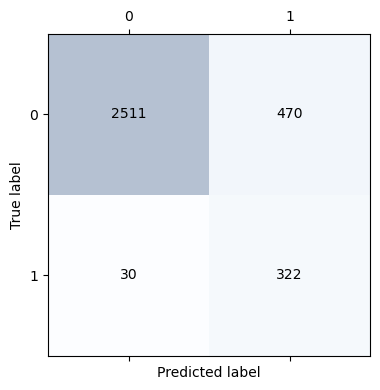


Accuracy: 0.84998499849985

              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91      2981
         1.0       0.41      0.91      0.56       352

    accuracy                           0.85      3333
   macro avg       0.70      0.88      0.74      3333
weighted avg       0.93      0.85      0.87      3333


5


In [61]:
clf5=tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=clfGS2.best_params_['min_samples_split'],min_impurity_decrease=clfGS2.best_params_['min_impurity_decrease'], max_depth= clfGS2.best_params_['max_depth'])
clf5 = clf5.fit(X_train, y_train)
pred = clf5.predict(X_test)

# Obtain accuracy score of learned classifier on test data
print(clf5.score(X_test, y_test))
confmat = confusion_matrix(y_test, pred)
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center',fontsize=10)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()
print()
print("Accuracy:", sklearn.metrics.accuracy_score(y_test, pred))
print()
print(sklearn.metrics.classification_report(y_test, pred))
epsilon = sklearn.metrics.accuracy_score(y_test, pred)
result = binomtest(k=int(epsilon*X_test.shape[0]), n=X_test.shape[0], p=0.05)
result.proportion_ci()

print()
print(clf5.tree_.max_depth)
#Print tree
fig = plt.gcf()
fig.set_size_inches(200, 100)

tree.plot_tree(clf5, filled=True,rounded=True,feature_names=list(X_train.columns.values))
fig.savefig('../Plots/Trees/treeDepth5.png')
plt.show()

As can be seen in the confusion matrix and in the metrics shown in both results (with depth = 9 and with depth = 5), the results are very similar. Therefore, a tree with lower depth is more general and less overfitted, so we will keep this one with depth 5.

In [68]:
feature_importances = pd.DataFrame(clf5.feature_importances_,
                                index = X_train.columns,
                                columns = ['importance']).sort_values('importance', 
                                                                    ascending=False)

display(feature_importances)

importance
duration                         0.540778
euribor3m                        0.187556
nr.employed                      0.122378
emp.var.rate                     0.063295
cons.conf.idx                    0.053233
month                            0.013904
age                              0.005121
pdays                            0.004011
poutcome_success                 0.002853
cons.price.idx                   0.002380
education_basic.6y               0.001589
campaign                         0.001457
job_housemaid                    0.001443
job_student                      0.000000
job_technician                   0.000000
job_unemployed                   0.000000
marital_single                   0.000000
job_unknown                      0.000000
loan                             0.000000
marital_married                  0.000000
job_self-employed                0.000000
marital_unknown                  0.000000
poutcome_nonexistent             0.000000
job_services                     0.000000
job_entrepreneur                 0.000000
job_retired                      0.000000
job_management                   0.000000
job_blue-collar                  0.000000
housing                          0.000000
education_unknown                0.000000
education_university.degree      0.000000
education_professional.course    0.000000
education_illiterate             0.000000
education_high.school            0.000000
education_basic.9y               0.000000
default_yes                      0.000000
default_unknown                  0.000000
day_of_week                      0.000000
contact                          0.000000
previous                         0.000000